# Лабораторная работа 5
# Выполнил Угарин Никита Александрович

## Задание 1: Прогнозирование временных рядов

Цели задания
1. Загрузить и предобработать данные временного ряда
2. Создать и обучить модель SimpleRNN для прогнозирования будущих значений
3. Создать и обучить модель LSTM для прогнозирования будущих значений
4. Создать и обучить модель Bidirectional LSTM для прогнозирования будущих значений
5. Сравнить производительность трех моделей и сделать выводы


### 1.Загрузка и предобработка данных

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Bidirectional
import math

Загрузка данных

In [60]:
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1])
data = dataset.values.astype('float32')

Нормализация данных

In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

Раззделение на обучающую и тестовые выборки

In [62]:
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(f"Размер обучающей выборки: {len(train)}, размер тестовой выборки: {len(test)}")

Размер обучающей выборки: 96, размер тестовой выборки: 48


Функция для создания датасета с временными шагами

In [63]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

Создание датасетов с временными шагами

In [64]:
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

Преобразование входных данных для RNN [samples, time steps, features]

In [65]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### 2.Создание и обучение модели SimpleRNN

Создание модели SimpleRNN


In [66]:
def create_simple_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Обучение модели SimpleRNN


In [67]:
simple_rnn_model = create_simple_rnn_model()
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=100, batch_size=32,
validation_data=(X_test, y_test), verbose=2)


Epoch 1/100


c:\python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 1s - 406ms/step - loss: 0.0501 - val_loss: 0.2356
Epoch 2/100
3/3 - 0s - 32ms/step - loss: 0.0305 - val_loss: 0.1612
Epoch 3/100
3/3 - 0s - 31ms/step - loss: 0.0191 - val_loss: 0.1073
Epoch 4/100
3/3 - 0s - 30ms/step - loss: 0.0109 - val_loss: 0.0670
Epoch 5/100
3/3 - 0s - 32ms/step - loss: 0.0061 - val_loss: 0.0401
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 0.0045 - val_loss: 0.0250
Epoch 7/100
3/3 - 0s - 32ms/step - loss: 0.0047 - val_loss: 0.0181
Epoch 8/100
3/3 - 0s - 30ms/step - loss: 0.0045 - val_loss: 0.0159
Epoch 9/100
3/3 - 0s - 32ms/step - loss: 0.0038 - val_loss: 0.0163
Epoch 10/100
3/3 - 0s - 31ms/step - loss: 0.0031 - val_loss: 0.0188
Epoch 11/100
3/3 - 0s - 31ms/step - loss: 0.0030 - val_loss: 0.0210
Epoch 12/100
3/3 - 0s - 30ms/step - loss: 0.0031 - val_loss: 0.0197
Epoch 13/100
3/3 - 0s - 30ms/step - loss: 0.0028 - val_loss: 0.0165
Epoch 14/100
3/3 - 0s - 30ms/step - loss: 0.0026 - val_loss: 0.0138
Epoch 15/100
3/3 - 0s - 30ms/step - loss: 0.0025 - val_loss: 0.0128


Прогнозирование

In [68]:
simple_rnn_train_predict = simple_rnn_model.predict(X_train)
simple_rnn_test_predict = simple_rnn_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Обратное преобразование прогнозов

In [69]:
simple_rnn_train_predict = scaler.inverse_transform(simple_rnn_train_predict)
simple_rnn_test_predict = scaler.inverse_transform(simple_rnn_test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])


Расчет RMSE

In [70]:
simple_rnn_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0],simple_rnn_train_predict[:,0]))
simple_rnn_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0],simple_rnn_test_predict[:,0]))
print(f'SimpleRNN - Ошибка на обучающей выборке (RMSE): {simple_rnn_train_rmse}')
print(f'SimpleRNN - Ошибка на тестовой выборке (RMSE): {simple_rnn_test_rmse}')


SimpleRNN - Ошибка на обучающей выборке (RMSE): 21.152813252845714
SimpleRNN - Ошибка на тестовой выборке (RMSE): 52.636031882444364


### 3.Создание и обучение модели LSTM

 Создание модели LSTM


In [71]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


 Обучение модели LSTM


In [72]:

lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,validation_data=(X_test, y_test), verbose=2)

Epoch 1/100


c:\python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 1s - 474ms/step - loss: 0.0690 - val_loss: 0.3980
Epoch 2/100
3/3 - 0s - 31ms/step - loss: 0.0626 - val_loss: 0.3748
Epoch 3/100
3/3 - 0s - 31ms/step - loss: 0.0573 - val_loss: 0.3526
Epoch 4/100
3/3 - 0s - 31ms/step - loss: 0.0520 - val_loss: 0.3315
Epoch 5/100
3/3 - 0s - 31ms/step - loss: 0.0471 - val_loss: 0.3111
Epoch 6/100
3/3 - 0s - 39ms/step - loss: 0.0428 - val_loss: 0.2913
Epoch 7/100
3/3 - 0s - 44ms/step - loss: 0.0384 - val_loss: 0.2721
Epoch 8/100
3/3 - 0s - 35ms/step - loss: 0.0345 - val_loss: 0.2534
Epoch 9/100
3/3 - 0s - 32ms/step - loss: 0.0304 - val_loss: 0.2349
Epoch 10/100
3/3 - 0s - 32ms/step - loss: 0.0268 - val_loss: 0.2164
Epoch 11/100
3/3 - 0s - 32ms/step - loss: 0.0234 - val_loss: 0.1981
Epoch 12/100
3/3 - 0s - 34ms/step - loss: 0.0204 - val_loss: 0.1797
Epoch 13/100
3/3 - 0s - 33ms/step - loss: 0.0177 - val_loss: 0.1610
Epoch 14/100
3/3 - 0s - 32ms/step - loss: 0.0154 - val_loss: 0.1427
Epoch 15/100
3/3 - 0s - 33ms/step - loss: 0.0138 - val_loss: 0.1253


Прогнозирование

In [73]:
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Обратное преобразование прогнозов


In [74]:
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)


Расчет RMSE

In [75]:
lstm_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0], lstm_train_predict[:,0]))
lstm_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0], lstm_test_predict[:,0]))
print(f'LSTM - Ошибка на обучающей выборке (RMSE): {lstm_train_rmse}')
print(f'LSTM - Ошибка на тестовой выборке (RMSE): {lstm_test_rmse}')


LSTM - Ошибка на обучающей выборке (RMSE): 29.370425271176096
LSTM - Ошибка на тестовой выборке (RMSE): 74.09867019751005


### 4.Создание и обучение модели Bidirectional LSTM

Создание модели Bidirectional LSTM

In [76]:
def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=50, activation='relu'), input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Обучение модели Bidirectional LSTM


In [77]:
bidirectional_lstm_model = create_bidirectional_lstm_model()
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,
                                                           validation_data=(X_test, y_test),verbose=2)

Epoch 1/100


c:\python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 2s - 826ms/step - loss: 0.0594 - val_loss: 0.3363
Epoch 2/100
3/3 - 0s - 33ms/step - loss: 0.0519 - val_loss: 0.3063
Epoch 3/100
3/3 - 0s - 34ms/step - loss: 0.0445 - val_loss: 0.2775
Epoch 4/100
3/3 - 0s - 32ms/step - loss: 0.0386 - val_loss: 0.2494
Epoch 5/100
3/3 - 0s - 32ms/step - loss: 0.0322 - val_loss: 0.2229
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 0.0271 - val_loss: 0.1974
Epoch 7/100
3/3 - 0s - 33ms/step - loss: 0.0224 - val_loss: 0.1735
Epoch 8/100
3/3 - 0s - 32ms/step - loss: 0.0184 - val_loss: 0.1510
Epoch 9/100
3/3 - 0s - 32ms/step - loss: 0.0152 - val_loss: 0.1300
Epoch 10/100
3/3 - 0s - 33ms/step - loss: 0.0130 - val_loss: 0.1104
Epoch 11/100
3/3 - 0s - 33ms/step - loss: 0.0109 - val_loss: 0.0936
Epoch 12/100
3/3 - 0s - 33ms/step - loss: 0.0099 - val_loss: 0.0796
Epoch 13/100
3/3 - 0s - 34ms/step - loss: 0.0096 - val_loss: 0.0686
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 0.0093 - val_loss: 0.0614
Epoch 15/100
3/3 - 0s - 32ms/step - loss: 0.0091 - val_loss: 0.0574


Прогнозирование

In [78]:
bidirectional_lstm_train_predict = bidirectional_lstm_model.predict(X_train)
bidirectional_lstm_test_predict = bidirectional_lstm_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Обратное преобразование прогнозов

In [79]:
bidirectional_lstm_train_predict = scaler.inverse_transform(bidirectional_lstm_train_predict)
bidirectional_lstm_test_predict = scaler.inverse_transform(bidirectional_lstm_test_predict)

Расчет RMSE

In [80]:
bidirectional_lstm_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0],bidirectional_lstm_train_predict[:,0]))
bidirectional_lstm_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0],bidirectional_lstm_test_predict[:,0]))
print(f'Bidirectional LSTM - Ошибка на обучающей выборке (RMSE):{bidirectional_lstm_train_rmse}')
print(f'Bidirectional LSTM - Ошибка на тестовой выборке (RMSE):{bidirectional_lstm_test_rmse}')

Bidirectional LSTM - Ошибка на обучающей выборке (RMSE):27.960152683644544
Bidirectional LSTM - Ошибка на тестовой выборке (RMSE):68.50229962985479


### 5.Визуализация результатов

Подготовка данных для визуализации

In [81]:
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[look_back:len(simple_rnn_train_predict) + look_back, :] = simple_rnn_train_predict
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(simple_rnn_train_predict) + (look_back * 2):len(data), :] = simple_rnn_test_predict

Визуализация результатов SimpleRNN


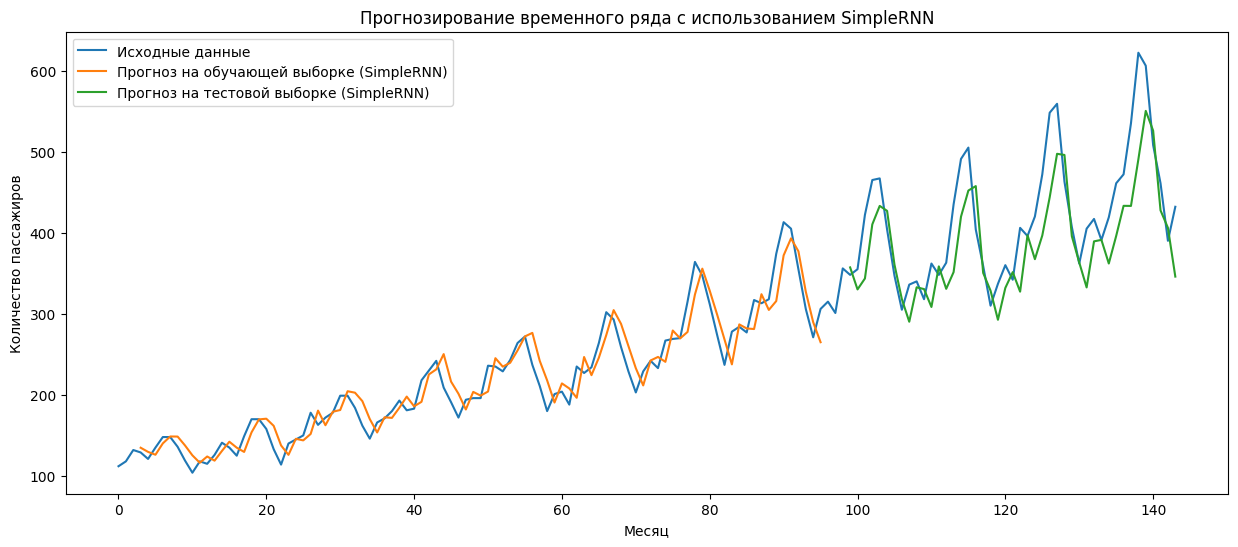

In [82]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(train_plot, label='Прогноз на обучающей выборке (SimpleRNN)')
plt.plot(test_plot, label='Прогноз на тестовой выборке (SimpleRNN)')
plt.title('Прогнозирование временного ряда с использованием SimpleRNN')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

### Визуалиация результатов LSTM

Подготовка данных

In [83]:
train_plot_lstm = np.empty_like(data)
train_plot_lstm[:, :] = np.nan
train_plot_lstm[look_back:len(lstm_train_predict)+look_back, :] = lstm_train_predict

test_plot_lstm = np.empty_like(data)
test_plot_lstm[:, :] = np.nan
test_plot_lstm[len(lstm_train_predict)+(look_back*2):len(data), :] = lstm_test_predict


Визуализация

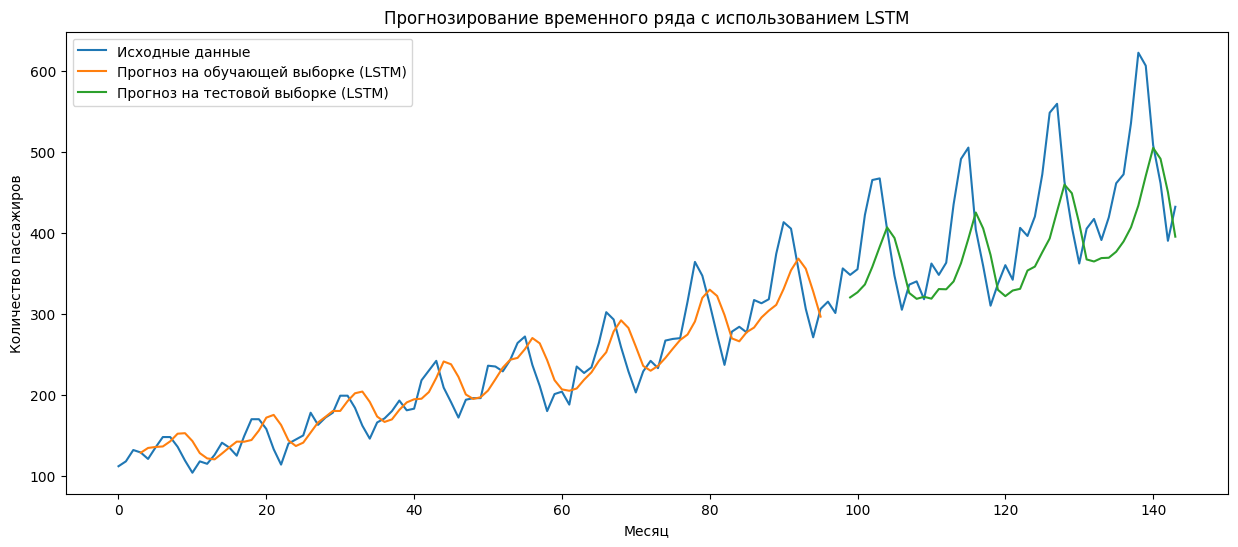

In [84]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(train_plot_lstm, label='Прогноз на обучающей выборке (LSTM)')
plt.plot(test_plot_lstm, label='Прогноз на тестовой выборке (LSTM)')
plt.title('Прогнозирование временного ряда с использованием LSTM')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

### Визуализация Bidirectional LSTM

Подготовка данных

In [85]:
bidirectional_train_plot = np.empty_like(data)
bidirectional_train_plot[:, :] = np.nan
bidirectional_train_plot[look_back:len(bidirectional_lstm_train_predict)+look_back, :] = bidirectional_lstm_train_predict

bidirectional_test_plot = np.empty_like(data)
bidirectional_test_plot[:, :] = np.nan
bidirectional_test_plot[len(bidirectional_lstm_train_predict)+(look_back*2):len(data), :] = bidirectional_lstm_test_predict

Визаулизация

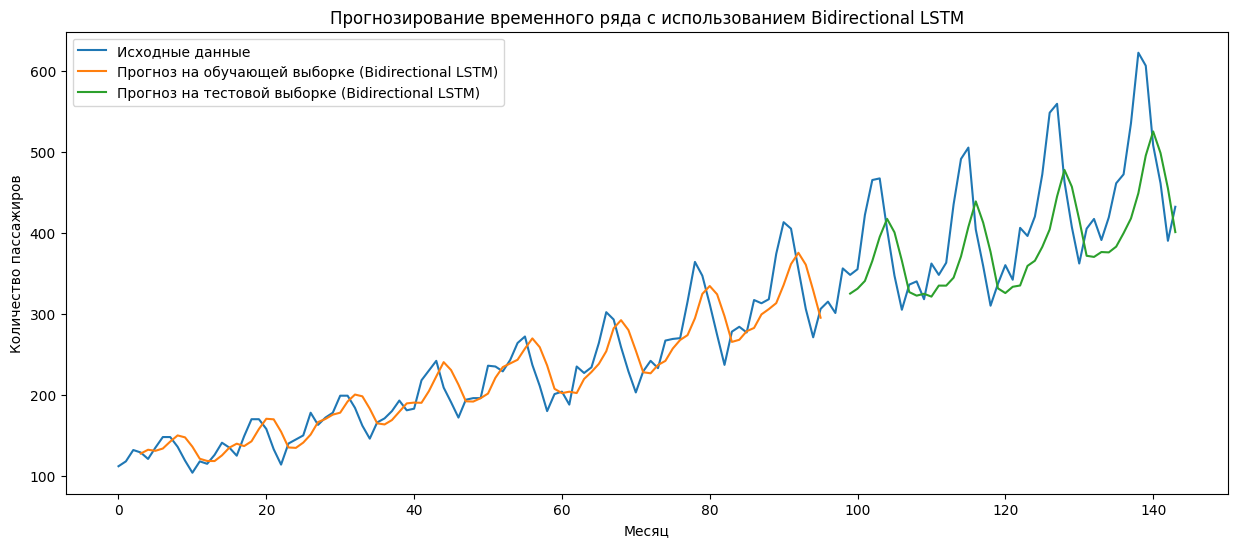

In [86]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(bidirectional_train_plot, label='Прогноз на обучающей выборке (Bidirectional LSTM)')
plt.plot(bidirectional_test_plot, label='Прогноз на тестовой выборке (Bidirectional LSTM)')
plt.title("Прогнозирование временного ряда с использованием Bidirectional LSTM")
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

### Сравнение ошибок моделей

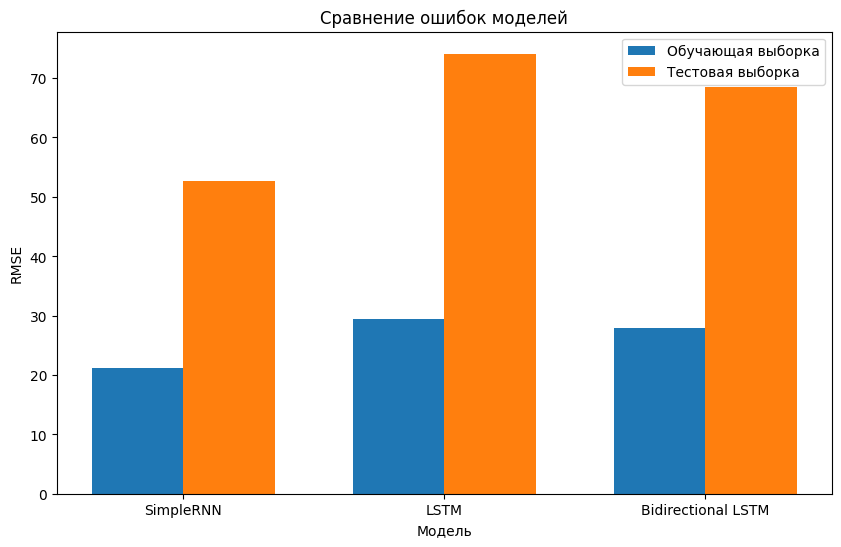

In [87]:
models = ['SimpleRNN', 'LSTM', 'Bidirectional LSTM']
train_rmse = [simple_rnn_train_rmse, lstm_train_rmse, bidirectional_lstm_train_rmse]
test_rmse = [simple_rnn_test_rmse, lstm_test_rmse, bidirectional_lstm_test_rmse]
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, train_rmse, width, label='Обучающая выборка')
plt.bar(x + width/2, test_rmse, width, label='Тестовая выборка')
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.title('Сравнение ошибок моделей')
plt.xticks(x, models)
plt.legend()
plt.show()


# Вывод: 
## 1. Я получил, что модель SimpleRNN выдала наименьшую ошибку на тестовой и обучающей выборке. 
## 2. Так как у всех моделей ошибка на тестовой выборке больше, чем на обучающей, то это означает что происходит переобучение (особенно у 2й и 3й модели).
## 3. Лучше всех справилась самая простая модель - SimpleRNN :) 